# MNIST for online classification: an ablation study

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import jax
import keras
import optax
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
from functools import partial
from jax.flatten_util import ravel_pytree

from methods import low_rank_filter_revised as lrkf
from methods import low_rank_last_layer as hilofi
from methods import low_rank_filter as lofi

In [5]:
sns.set_palette("colorblind")

In [6]:
%config InlineBackend.figure_format = "retina"

## Load dataset

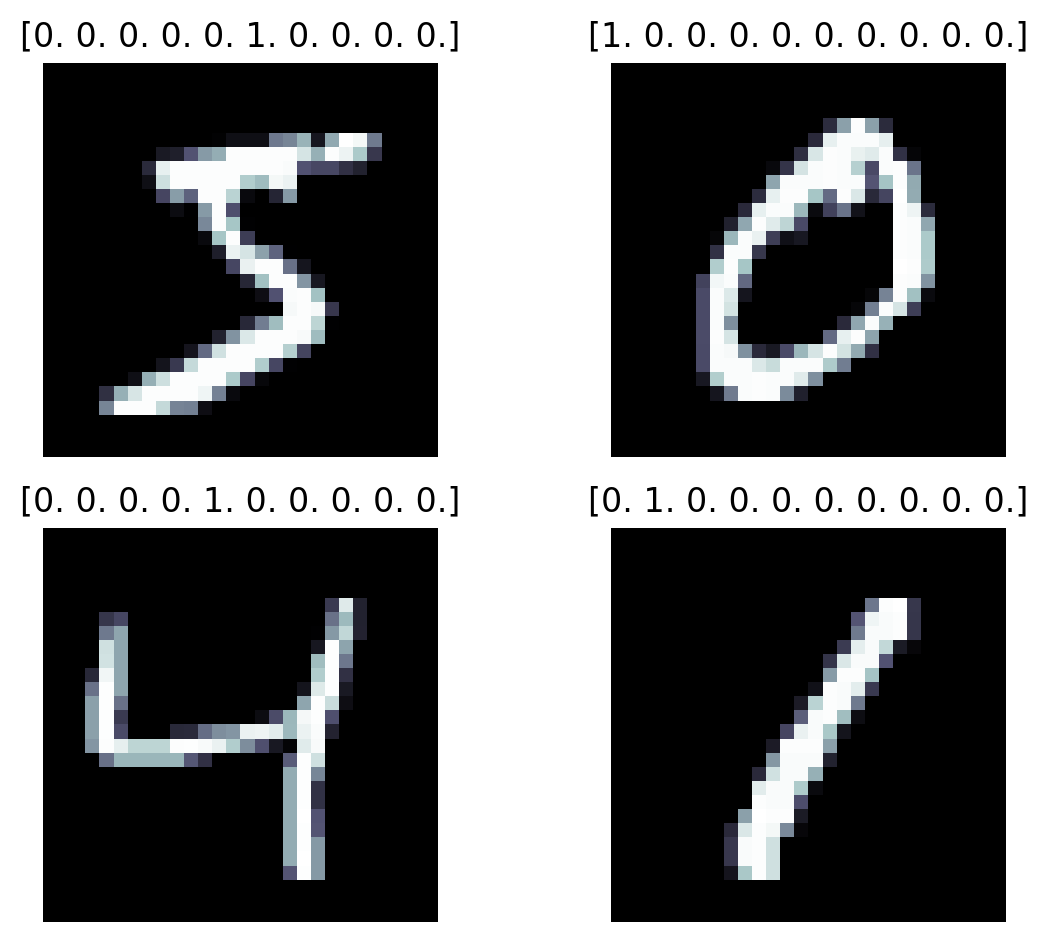

In [7]:
# (X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
# X_train = einops.rearrange(X_train, "s w h -> s (w h)") / 255
# X_test = einops.rearrange(X_test, "s w h -> s (w h)") / 255
X_train = X_train[..., None] / 255
X_test = X_test[..., None] / 255
y_train = jax.nn.one_hot(y_train, 10)
X_train = jnp.array(X_train)
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.ravel()):
    ax.imshow(X_train[i], cmap="bone")
    ax.set_title(y_train[i])
    ax.axis("off")
plt.tight_layout()

## Train

In [8]:
X_eval = X_test[:5_000]
y_eval = y_test[:5_000]

In [9]:
class CNN(nn.Module):
    num_arms: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        x = nn.elu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.elu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.elu(x)
        x = nn.Dense(features=84)(x)
        x = nn.elu(x)
        x = nn.Dense(10, name="last_layer")(x)
        return x.squeeze()

model = CNN()

In [10]:
def plot_err_bound(df, ax, label, periods=5000, min_periods=None):
    min_periods = periods if min_periods is None else min_periods
    df.rolling(periods, min_periods=min_periods).mean().mean(axis=1).plot(label=label, ax=ax)

## Revised version

In [11]:
def callbackfn(bel_update, bel_pred, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat = agent.predict_fn(bel_pred, x)
    acc = y.argmax() == yhat.argmax()
    return acc, bel_update.epull, bel_update.econs

In [12]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=0.1):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [13]:
n_sims = 1
keys = jax.random.PRNGKey(314)
keys = jax.random.split(keys, n_sims)
model = CNN()

In [14]:
n_obs = len(X_train)

In [15]:
%%time

def run_lrkf(key, rank=20):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    params = model.init(key_init, X_train[:1])
    agent = lrkf.LowRankCovarianceFilter(
        mean_fn,
        cov_fn,
        dynamics_covariance=0.01,
        rank=rank,
    )
    bel_init = agent.init_bel(params, cov=1.0, low_rank_diag=True)
    
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lrkf = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist_lrkf

hist_lrkf = jax.vmap(run_lrkf)(keys)
hist_lrk = jax.tree.map(np.array, hist_lrkf)

CPU times: user 25.3 s, sys: 137 ms, total: 25.4 s
Wall time: 57.1 s


In [16]:
df_lrkf = pd.DataFrame(hist_lrkf[0].T)
df_lrkf.shape

(60000, 1)

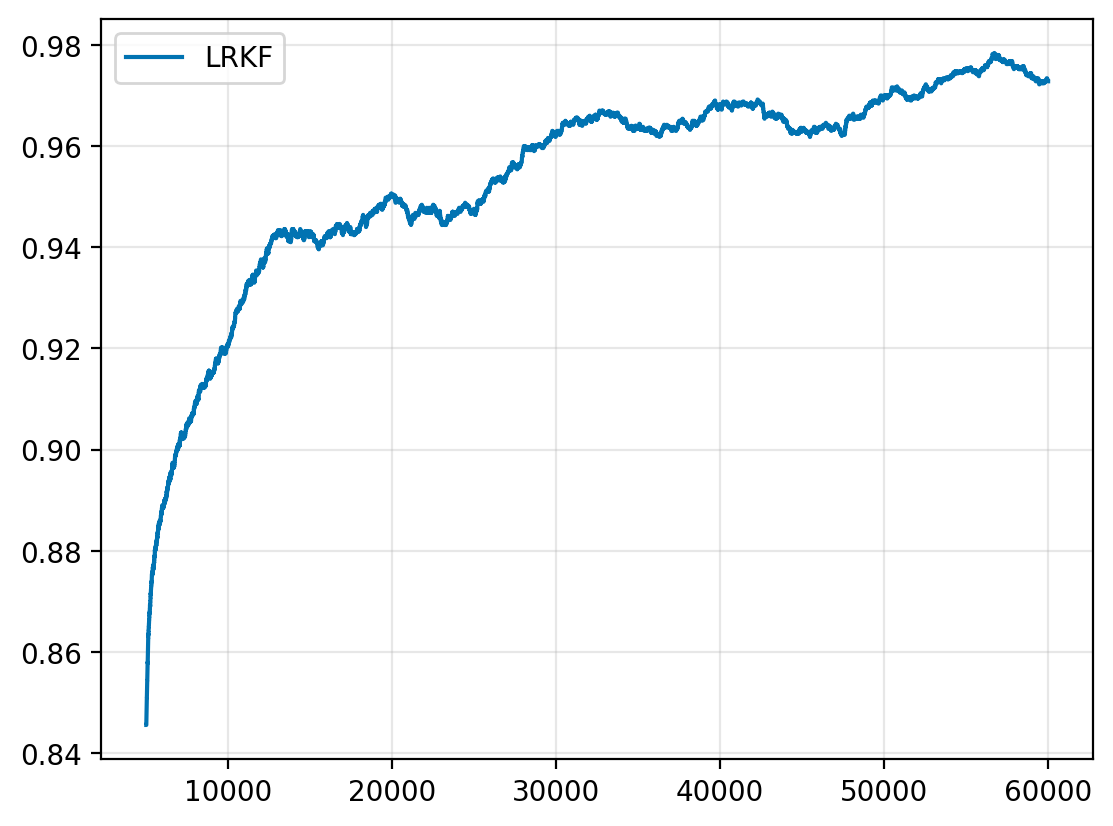

In [17]:
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plt.legend()
plt.grid(alpha=0.3)

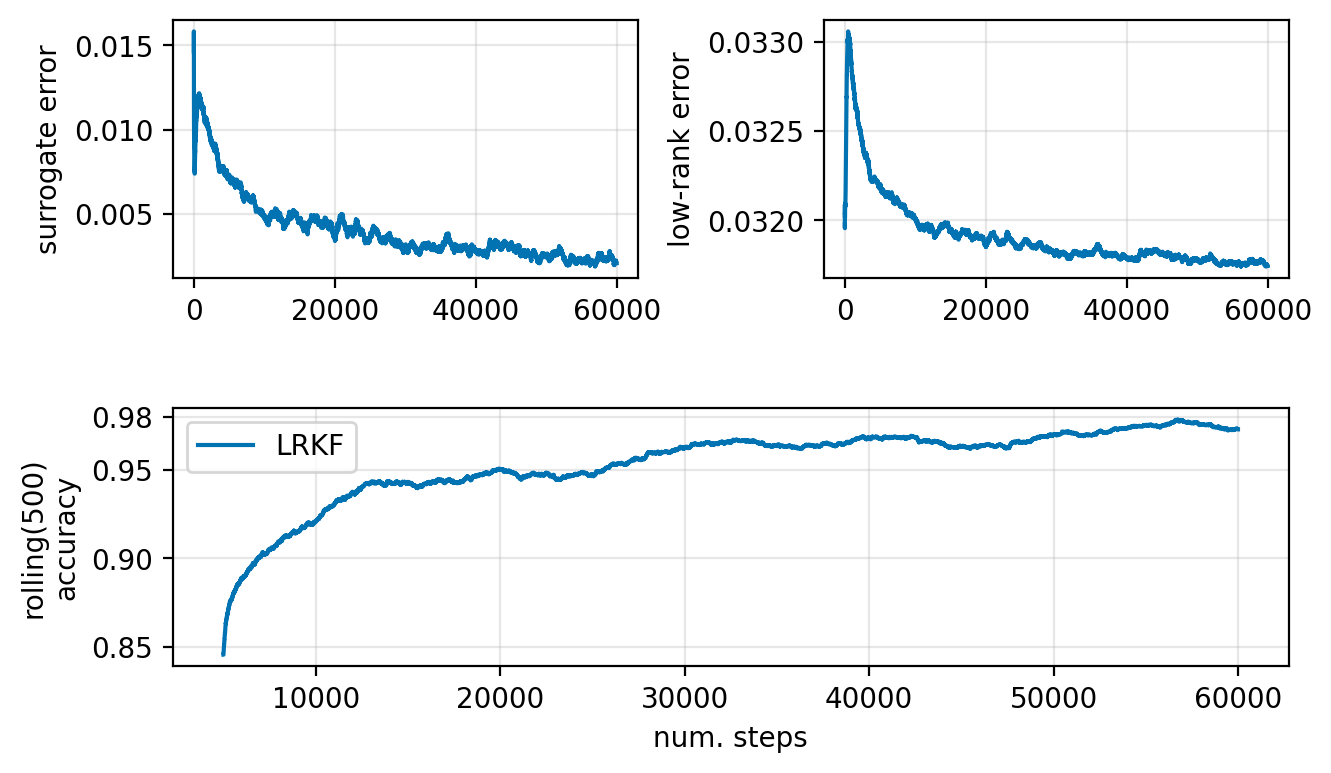

In [18]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 2, hspace=0.5, wspace=0.4)
fig = plt.figure(figsize=(7.2, 4.2 ))

ax1 = fig.add_subplot(gs[0])
plt.sca(ax1)
pd.Series(np.array(hist_lrkf[1].ravel())).ewm(span=1000).mean().plot(ax=ax1)
plt.ylabel("surrogate error")
plt.grid(alpha=0.3)

ax2 = fig.add_subplot(gs[1])
plt.sca(ax2)
pd.Series(np.array(hist_lrkf[2].ravel())).ewm(span=1000).mean().plot(ax=ax2)
plt.ylabel("low-rank error")
plt.grid(alpha=0.3)

ax3 = fig.add_subplot(gs[2:])
plt.sca(ax3)
plot_err_bound(df_lrkf, ax3, "LRKF", min_periods=5000)
plt.legend()
plt.ylabel("rolling(500)\naccuracy")
plt.xlabel("num. steps")
plt.yticks([0.85, 0.90, 0.95, 0.98])
plt.grid(alpha=0.3)

plt.savefig("../figures/mnist-lrkf-error-analysis.png", dpi=300, bbox_inches="tight")

# LoLoFi

In [19]:
def callbackfn(bel_update, bel_pred, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat = agent.predict_fn(bel_pred, x)
    acc = y.argmax() == yhat.argmax()
    return acc

In [20]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=1e-4):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [21]:
%%time
def run_lolofi(key, rank=100):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    agent = hilofi.LowRankLastLayer(
        mean_fn, cov_fn, rank=rank, rank_last=50,
        # dynamics_hidden=1e-6, dynamics_last=1e-6,
        dynamics_hidden=0.01, dynamics_last=0.01,
    )
    params = model.init(key, X_train[:100])
    
    bel_init = agent.init_bel(params, cov_hidden=1.0, cov_last=1.0, low_rank_diag=True)
    
    cfn = partial(callbackfn, agent=agent)
    bel_hilofi, hist_hilofi = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    
    return hist_hilofi

CPU times: user 45 μs, sys: 0 ns, total: 45 μs
Wall time: 93.5 μs


## HiLoFi

In [22]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=1e-4):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [23]:
%%time
def run_hilofi(key, rank=50):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    agent = hilofi.LowRankLastLayer(
        mean_fn, cov_fn, rank=rank, rank_last=None,
        dynamics_hidden=0.01, dynamics_last=0.01,
    )
    params = model.init(key, X_train[:100])
    
    bel_init = agent.init_bel(params, cov_hidden=1.0, cov_last=1.0, low_rank_diag=True)
    
    cfn = partial(callbackfn, agent=agent)
    bel_hilofi, hist_hilofi = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    
    return hist_hilofi

CPU times: user 0 ns, sys: 79 μs, total: 79 μs
Wall time: 158 μs


## Low-rank (precision) filter (LoFi)

In [24]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=0.01):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [25]:
%%time

def run_lofi(key, rank=50):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    agent = lofi.LowRankPrecisionFilter(
        mean_fn, cov_fn, rank=rank, dynamics_covariance=0.0,
    )
    params = model.init(key_init, X_train[:100])
    
    bel_init = agent.init_bel(params, cov=jnp.exp(-8))
    
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lofi = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist_lofi

CPU times: user 42 μs, sys: 4 μs, total: 46 μs
Wall time: 98.9 μs


## Time / performance of LoFi / LRKF / HiLoFi / LoLoFi

In [26]:
key = jax.random.PRNGKey(314)

In [27]:
ranks = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


result = []
for rank in tqdm(ranks):
    time_init = time()
    hist = run_lrkf(key, rank)
    hist = jax.tree.map(np.array, hist)
    time_end = time()
    running_time = time_end - time_init
    result.append({
        "method": "LRKF",
        "running_time": running_time,
        "accuracy": hist[5000:],
        "rank": rank,
    })

    time_init = time()
    hist = run_lofi(key, rank)
    hist = jax.tree.map(np.array, hist)
    time_end = time()
    running_time = time_end - time_init
    result.append({
        "method": "LoFi",
        "running_time": running_time,
        "accuracy": hist[5000:],
        "rank": rank,
    })


    time_init = time()
    hist = run_lolofi(key, rank)
    hist = jax.tree.map(np.array, hist)
    time_end = time()
    running_time = time_end - time_init
    result.append({
        "method": "LoLoFi",
        "running_time": running_time,
        "accuracy": hist[5000:],
        "rank": rank,
    })

    
    time_init = time()
    hist = run_hilofi(key, rank)
    hist = jax.tree.map(np.array, hist)
    time_end = time()
    running_time = time_end - time_init
    result.append({
        "method": "HiLoFi",
        "running_time": running_time,
        "accuracy": hist[5000:],
        "rank": rank,
    })

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [44:06<00:00, 220.57s/it]


In [28]:
df_result = pd.DataFrame(result)

df_result["accuracy"] = df_result["accuracy"].apply(lambda x: x[-10_000:].mean())

Text(0, 0.5, 'running time')

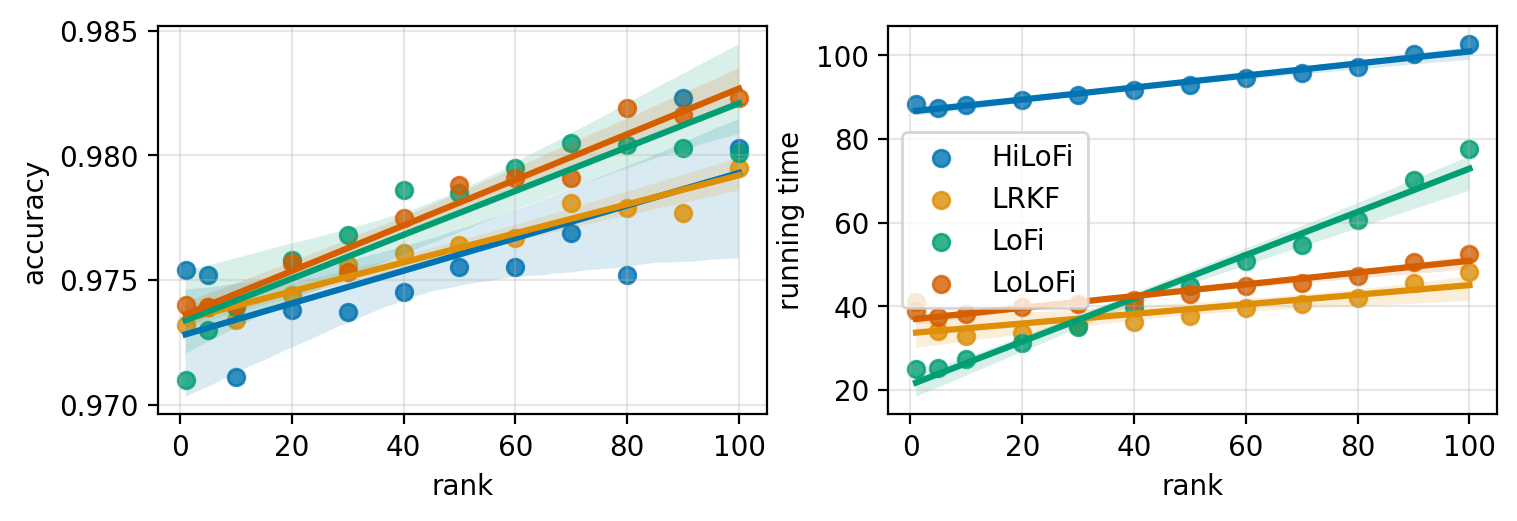

In [29]:
methods = df_result["method"].unique()
fig, axs = plt.subplots(1, 2, figsize=(7.2 * 1.2, 4.2 * 0.6))

plt.sca(axs[0])
for method in sorted(methods):
    sns.regplot(x="rank", y="accuracy", data=df_result.query("method == @method"), ax=axs[0], label=method)
axs[0].grid(alpha=0.3)
# plt.legend()

plt.sca(axs[1])
for method in sorted(methods):
    sns.regplot(x="rank", y="running_time", data=df_result.query("method == @method"), ax=axs[1], label=method)
axs[1].grid(alpha=0.3)
axs[1].legend()
axs[1].set_ylabel("running time")
# plt.savefig("../figures/mnist-online-classification-rank-comparison.png", dpi=300, bbox_inches="tight")